# PI Control Example
also featuring computation delays and firing rate estimates

In [1]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import matplotlib.pyplot as plt
from cleosim import *

np.random.seed(7000)

# the default cython compilation target isn't worth it for 
# this trivial example
prefs.codegen.target = "numpy"

## Create the Brian network
We'll create a population of 10 neurons mainly driven by feedforward input but with some recurrent connections as well.

In [2]:
n = 10
population = NeuronGroup(n, '''
            dv/dt = (-v - 70*mV + Rm*I) / tau : volt
            tau: second
            Rm: ohm
            I: amp''',
        threshold='v>-50*mV',
        reset='v=-70*mV'
)
population.tau = 10*ms
population.Rm = 100*Mohm
population.I = 0*mA
population.v = -70*mV

input_group = PoissonGroup(n, np.linspace(20, 200, n)*Hz)

S = Synapses(input_group, population, on_pre='v+=5*mV')
S.connect(condition=f'abs(i-j)<={3}')
S2 = Synapses(population, population, on_pre='v+=2*mV')
# S2.connect(condition=f'abs(i-j)<={1}')
S2.connect(p=0.2)

pop_mon = SpikeMonitor(population)

net = Network(population, input_group, S, S2, pop_mon)

### Run simulation without control:

In [3]:
net.run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.16s). [brian2.stateupdaters.base.method_choice]


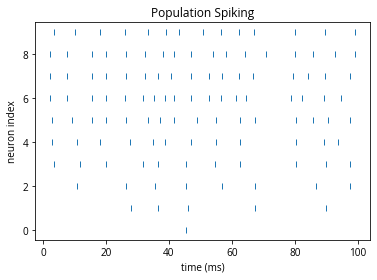

In [4]:
plt.figure();
plt.plot(pop_mon.t / ms, pop_mon.i, '|'); 
plt.title('Population Spiking'); plt.ylabel('neuron index'); plt.xlabel('time (ms)');

## Control loop setup
Now for the control loop--to control neuron $i$, we need to:
- capture spiking using a `SpikeRecorder`
- estimating its firing rate using a `FiringRateEstimator`
- compute the stimulus intensity with a `PIController`
- pass that to a `StateVariableSetter` stimulator manipulating input current

In [5]:
from cleosim import *
from cleosim.recorders import GroundTruthSpikeRecorder
from cleosim.stimulators import StateVariableSetter

i = 0  # neuron to control

sim = CLSimulator(net)
rec = GroundTruthSpikeRecorder('spike_rec')
sim.inject_recorder(rec, population[i])

Note that we can set delays for components in the control loop to better
approximate the experiment:

In [6]:
from cleosim.processing import (
    LatencyProcessingLoop,
    FiringRateEstimator,
    ConstantDelay,
    PIController,
)

# the target firing rate trajectory, as a function of time
def target_Hz(t_ms):
    if t_ms < 250:  # constant target at first
        return 400
    else:  # sinusoidal afterwards
        a = 200
        t_s = t_ms / 1000
        return a + a * np.sin(2 * np.pi * 20 * t_s)


class PIRateProcessingLoop(LatencyProcessingLoop):
    delta = 1  # ms

    def __init__(self):
        super().__init__(self.delta, sampling="fixed", processing="parallel")
        self.rate_estimator = FiringRateEstimator(
            15, self.delta, delay=ConstantDelay(4.1), save_history=True
        )

        # using hand-tuned gains that seem reasonable
        self.pi_controller = PIController(
            target_Hz,
            Kp=0.005,
            Ki=0.04,
            sample_period_ms=self.delta,
            delay=ConstantDelay(2.87),  # 2.87 ms latency
            save_history=False,
        )

    def compute_ctrl_signal(self, state_dict, sample_time_ms):
        spikes = state_dict["spike_rec"]
        out, time_ms = self.rate_estimator.process(
            spikes, sample_time_ms, sample_time_ms=sample_time_ms
        )
        out, time_ms = self.pi_controller.process(
            out, time_ms, sample_time_ms=sample_time_ms
        )
        # this dictionary output format allows for the flexibility
        # of controlling multiple stimulators
        if out < 0:  # limit to positive current
            out = 0
        out_dict = {"I_stim": out}
        return out_dict, time_ms


proc_loop = PIRateProcessingLoop()
sim.set_processing_loop(proc_loop)

Now we inject the stimulator:

In [7]:
sim.inject_stimulator(
        StateVariableSetter(
            'I_stim', variable_to_ctrl='I', unit=nA),
        population[i]
)

## Run the simulation

In [8]:
sim.run(300*ms)

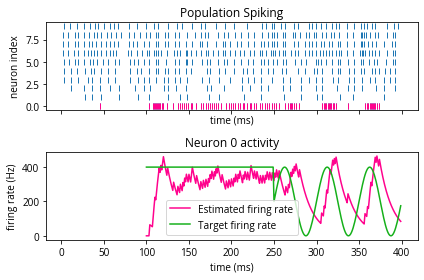

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True);
ax1.plot(pop_mon.t / ms, pop_mon.i, '|');
ax1.plot(pop_mon.t[pop_mon.i == i]/ms, pop_mon.i[pop_mon.i==i], '|', c='xkcd:hot pink') 
ax1.set(title='Population Spiking', ylabel='neuron index', xlabel='time (ms)')

ax2.plot(proc_loop.rate_estimator.t, proc_loop.rate_estimator.values, c='xkcd:hot pink');
ax2.plot(proc_loop.rate_estimator.t, [target_Hz(t) for t in proc_loop.rate_estimator.t],\
         c='xkcd:green');
ax2.set(ylabel='firing rate (Hz)', xlabel='time (ms)', title=f'Neuron {i} activity');
ax2.legend(['Estimated firing rate', 'Target firing rate']);

fig.tight_layout()
fig.show()

_Note the lag in keeping up with the target firing rate, which can
be directly attributed to the ~7 ms delay we coded in to the control loop._